In [1]:
pwd

'c:\\Users\\user\\KeepMeSafe\\AI_Project'

In [28]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")        
    print("CUDA is not available. Using CPU.")


CUDA is not available. Using CPU.


In [50]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 라이브러리

# 가정: 'real.csv' 파일에 분석할 실제 데이터가 있으며,
# 여기서는 이미 준비된 10개의 데이터를 사용한다고 가정합니다.

# 데이터 불러오기 및 전처리 (10개 데이터 예시)
df = pd.read_csv("../data/user_code_total/user_code_006.csv")
# df['RegisterDate'] = pd.to_datetime(df['RegisterDate'])
# df.sort_values(by='RegisterDate', inplace=True)
# df.fillna(method='ffill', inplace=True)
df = df.tail(10)  # 최근 10개 데이터만 사용

# # 심박수 데이터 추출 및 스케일링
# heartbeat_data = df['Heartbeat'].values.reshape(-1, 1)
# scaler = MinMaxScaler(feature_range=(0, 1))
# heartbeat_data_scaled = scaler.fit_transform(heartbeat_data)


# 심박수, 온도, 외부 온도 데이터 추출 및 스케일링
features_data = df[['Heartbeat']].values
scaler = MinMaxScaler(feature_range=(0, 1))
features_data_scaled = scaler.fit_transform(features_data)

# PyTorch 텐서로 변환 및 차원 조정
# X = torch.Tensor(heartbeat_data_scaled).unsqueeze(2)  # [1, 10, 1] 형태로 변환
X = torch.Tensor(features_data_scaled).unsqueeze(1)  # [10, 1, 3] 형태로 변환


# LSTM 기반 오토인코더 모델 정의 (변경 없음)
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(Autoencoder, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        _, (hn, _) = self.encoder(x)
        hn = hn[-1].unsqueeze(0)
        repeated_hn = hn.repeat(1, x.size(1), 1)
        decoded, _ = self.decoder(repeated_hn)
        decoded = decoded.contiguous().view(-1, x.size(2))
        decoded = self.linear(decoded)
        return decoded.view(x.size(0), x.size(1), -1)

# 모델 불러오기 (가정: 학습된 모델이 'best_model.pth'에 저장되어 있음)
model_path = './trainedModel/best_model_user_code_6.pth'
model = Autoencoder(input_dim=1, hidden_dim=50, num_layers=2).to(device) #input-dim 1->3
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# 데이터에 대한 예측 수행 및 재구성 오차 계산
criterion = torch.nn.MSELoss()  # 평균 제곱 오차 손실 함수
with torch.no_grad():
    outputs = model(X)
    reconstruction_errors = criterion(outputs, X).item()

print(f'재구성 오차: {reconstruction_errors}')

# 재구성 오차를 기반으로 필요한 분석 수행
# 예를 들어, 특정 임계값을 기반으로 이상치 판단 등


재구성 오차: 0.00997199211269617


In [51]:
df.tail(10)

,No,WorkDate,UserCode,Heartbeat,Temperature,OutsideTemperature,RegisterDate
29637,21111021,20231114,6,93,32.554306,34,2023-11-14 15:14
29638,21111032,20231114,6,92,32.554306,34,2023-11-14 15:14
29639,21111042,20231114,6,92,32.554306,34,2023-11-14 15:14
29640,21111049,20231114,6,93,32.554306,34,2023-11-14 15:14
29641,21111066,20231114,6,93,32.266605,34,2023-11-14 15:14
29642,21111082,20231114,6,93,32.266605,34,2023-11-14 15:14
29643,21111098,20231114,6,93,32.266605,34,2023-11-14 15:14
29644,21111115,20231114,6,93,32.266605,34,2023-11-14 15:14
29645,21111139,20231114,6,94,29.226099,34,2023-11-14 15:14
29646,21111149,20231114,6,93,29.226099,34,2023-11-14 15:14


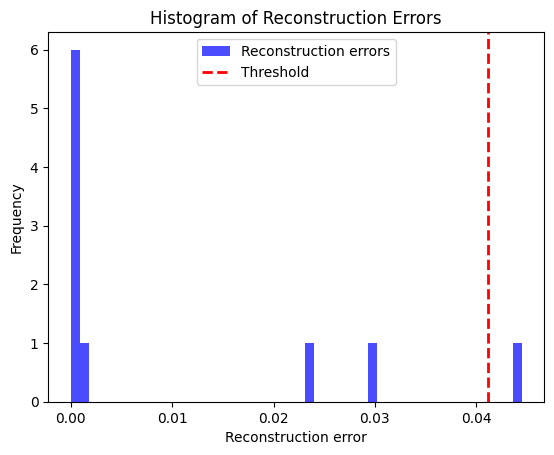

In [52]:
# 재구성 오차 계산
criterion = torch.nn.MSELoss()
reconstruction_errors = []

with torch.no_grad():
    outputs = model(X)
    for i in range(X.size(0)):
        loss = criterion(outputs[i], X[i]).item()
        reconstruction_errors.append(loss)

# 임계값 설정 (이전에 정의한 방식을 그대로 사용)
mean_reconstruction_error = np.mean(reconstruction_errors)
std_reconstruction_error = np.std(reconstruction_errors)
threshold = mean_reconstruction_error + 2 * std_reconstruction_error

# 재구성 오차 시각화
plt.hist(reconstruction_errors, bins=50, alpha=0.7, color='blue', label='Reconstruction errors')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

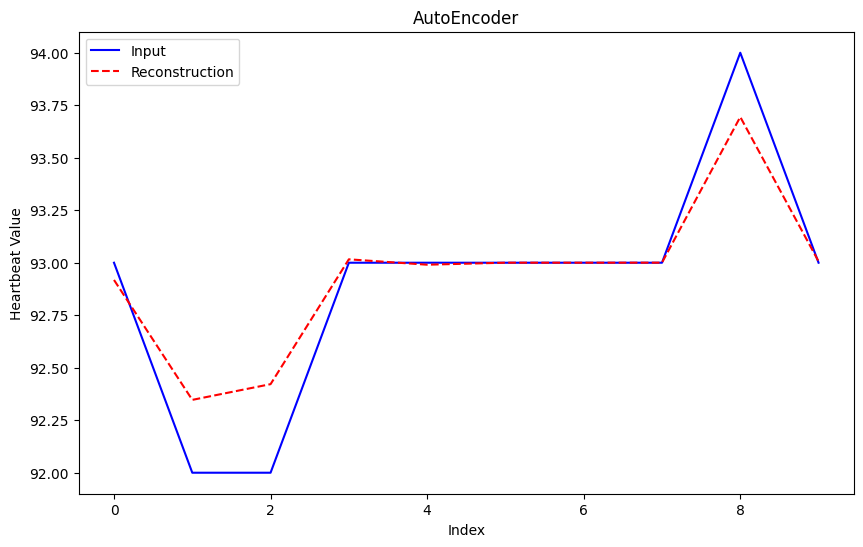

In [53]:
import matplotlib.pyplot as plt

# 예측된 'Heartbeat' 데이터 스케일 되돌리기
predicted_heartbeat = outputs.squeeze(2).detach().numpy()  # 모델 출력을 numpy 배열로 변환
predicted_heartbeat_scaled = scaler.inverse_transform(predicted_heartbeat)  # MinMaxScaler를 사용해 원본 스케일로 변환

# 원본 'Heartbeat' 데이터
original_heartbeat = df['Heartbeat'].values

# 그래프 그리기
plt.figure(figsize=(10, 6))

# 원본 'Heartbeat' 데이터 그래프
plt.plot(original_heartbeat, label='Input', color='blue')

# 예측된 'Heartbeat' 데이터 그래프
plt.plot(predicted_heartbeat_scaled, label='Reconstruction', color='red', linestyle='--')

plt.title('AutoEncoder')
plt.xlabel('Index')
plt.ylabel('Heartbeat Value')
plt.legend()
plt.show()


In [54]:
# 재구성 오차를 기반으로 이상치를 식별합니다.
anomalies = [i for i, error in enumerate(reconstruction_errors) if error > threshold]

# 결과 DataFrame 초기화
results = pd.DataFrame({
    'status': ['SAFE'] * len(df),  # 초기 상태를 'SAFE'로 설정
    'worker_id': df['UserCode'].values  # 'UserCode'를 'worker_id'로 사용
})

# 이상치에 대한 상태를 'CAUTION'으로 업데이트
for idx in anomalies:
    if idx < len(results):  # 인덱스가 결과 DataFrame의 범위 내에 있는지 확인
        results.at[idx, 'status'] = 'CAUTION'
        
print(results)

    status  worker_id
0     SAFE          6
1     SAFE          6
2  CAUTION          6
3     SAFE          6
4     SAFE          6
5     SAFE          6
6     SAFE          6
7     SAFE          6
8     SAFE          6
9     SAFE          6


In [55]:
# 'status' 열에서 'CAUTION'이 하나라도 있는지 검사
if 'CAUTION' in results['status'].values:
    overall_status = 'CAUTION'
else:
    overall_status = 'SAFE'

# JSON 형식으로 결과 반환
result = {
    'status': overall_status,
    'worker_id': df['UserCode'].values[0]  # 리스트로 감싸 단일 값으로 설정
}

print(result)

{'status': 'CAUTION', 'worker_id': 6}
